In [29]:
# Import the required libraries and dependencies
import os
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import sqlalchemy

# Add viz libs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import hvplot.pandas
import altair as alt 
from bokeh.plotting import figure, show
import folium

## Clean data

In [30]:
# Force clean vars
force_clean_large_kickstarter = True
force_clean_small_kickstarter = True
force_clean_indiegogo = True

# Clean large kickstarter
my_kickstarter_large_file = Path('./Resources/kickstarter_data_clean/ks-projects-large.csv')
if not my_kickstarter_large_file.is_file() or force_clean_large_kickstarter:
    %run ./Resources/Utils/clean_kickstarter_large.ipynb

# Clean small kickstarter
my_kickstarter_small_file = Path('./Resources/kickstarter_data_clean/ks-projects-small.csv')
if not my_kickstarter_small_file.is_file() or force_clean_small_kickstarter:
    %run ./Resources/Utils/clean_kickstarter_small.ipynb

# Clean indiegogo kickstarter
my_indiegogo_file = Path('./Resources/indiegogo_data_clean/indiegogo-projects.csv')
if not my_indiegogo_file.is_file() or force_clean_indiegogo:
    %run ./Resources/Utils/clean_indiegogo.ipynb

## Enable Mapbox API access token

In [31]:
# Load the .env file into the notebook
load_dotenv()

# Read in your MAPBOX_API_KEY
mapbox_api_access_token = os.getenv('MAPBOX_API_ACCESS_TOKEN')

# Confirm the availability of your Mapbox API access token by checking its type
display(type(mapbox_api_access_token))

# Set your Mapbox API access token
px.set_mapbox_access_token(mapbox_api_access_token)

str

## Read kickstarter large

In [18]:
# Import small kickstarter most backed dataset
kickstarter_large_clean_df = pd.read_csv(
    Path('./Resources/kickstarter_data_clean/ks-projects-large.csv')
)

# Fix dates
kickstarter_large_clean_df['launched'] = pd.to_datetime(kickstarter_large_clean_df['launched'])
kickstarter_large_clean_df['deadline'] = pd.to_datetime(kickstarter_large_clean_df['deadline'])

# View head
kickstarter_large_clean_df.head(2)

,ID,name,main_category,currency,usd_goal_real,usd_pledged_real,deadline,launched,state,funded_percent,duration,daily_goal,daily_pledged,country,full_country_names,lat,long,avg_backer_per_day,pledged_per_person
0,1000002330,The Songs of Adelaide & Abullah,Publishing,GBP,1533.95,0.0,2015-10-09,2015-08-11 12:12:28,0,0.0000,58,26.45,0.00,GB,United Kingdom,55.378051,-3.435973,0.00,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Film & Video,USD,30000.00,2421.0,2017-11-01,2017-09-02 04:43:57,0,0.0807,59,508.47,41.03,US,United States,37.090240,-95.712891,0.25,161.4


## Read kickstarter small

In [19]:
# Import small kickstarter most backed dataset
kickstarter_small_clean_df = pd.read_csv(
    Path('./Resources/kickstarter_data_clean/ks-projects-small.csv')
)

# View head
kickstarter_small_clean_df.head(2)

,ID,name,main_category,currency,usd_goal_real,usd_pledged_real,location,backers,num.backers.tier,pledge.tier
0,0,Exploding Kittens,Tabletop Games,USD,10000.0,8782571.0,"Los Angeles, CA",219382,"[15505, 202934, 200, 5]","[20.0, 35.0, 100.0, 500.0]"
1,1,Fidget Cube: A Vinyl Desk Toy,Product Design,USD,15000.0,6465690.0,"Denver, CO",154926,"[788, 250, 43073, 21796, 41727, 21627, 12215, ...","[1.0, 14.0, 19.0, 19.0, 35.0, 35.0, 79.0, 79.0..."


## Read indiegogo

In [20]:
# Import indiegogo dataset
indiegogo_clean_df = pd.read_csv(
    Path('./Resources/indiegogo_data_clean/indiegogo-projects.csv')
)

# Fix dates
indiegogo_clean_df['launched'] = pd.to_datetime(indiegogo_clean_df['launched'])
indiegogo_clean_df['deadline'] = pd.to_datetime(indiegogo_clean_df['deadline'])

# View head
indiegogo_clean_df.head(2)

,ID,name,main_category,category,currency,usd_goal_real,usd_pledged_real,deadline,launched,state,funded_percent,duration,daily_goal,daily_pledged,country,full_country_names,lat,long
0,3936,Join the Electric Revolution!!!,Technology,Transportation,USD,5000.0,840.0,2010-05-12 23:59:00,2010-04-21 22:38:42,0,0.1680,21,238.10,40.00,US,United States,37.09024,-95.712891
1,5109,Relief Trip to Haiti,Journalism,Human Rights,USD,1200.0,250.0,2010-07-02 23:59:00,2010-06-10 17:47:35,0,0.2083,22,54.55,11.36,US,United States,37.09024,-95.712891


## Add SQL database and simple functions to load and access tables in that database

In [21]:
# Establishes Database Connection with a temporary SQL db (we can update to give it a name later)
database_connection_string = "sqlite:///"

engine = sqlalchemy.create_engine(database_connection_string)

# Function to load table into DB
# data is the dataframe we want to save, 
# table name is the name of the new table (as a string value), 
# and engine is the engine input established earlier
def new_table(data, table_name):
    data.to_sql(f"{table_name}", engine, index=True, if_exists="replace")


# Lets us load the table of our choice from the database, just set the function equal to a new dataframe variable and run 
# must set the table name as a string value
def load_full_table(table_name):
    new_df = pd.read_sql_table(f"{table_name}", con=engine )
    return new_df

new_table(kickstarter_large_clean_df, "kickstarter_large")
new_table(kickstarter_small_clean_df, "kickstarter_small")
new_table(indiegogo_clean_df, "indie_gogo")


## Add SQL query to access main_category and mean of duration of projects for Kickstarter and Indiegogo.

In [22]:
# Create a SQL query to get the main_category and duration of the Kickstarter Large dataframe.
query_ks = """
SELECT main_category, duration
FROM kickstarter_large
"""
query_indiegogo = """
SELECT main_category, duration
FROM indie_gogo
"""

# This will let us read the query we applied earlier to create a dataframe.
ks_large_duration_dataframe = pd.read_sql_query(
    query_ks, 
    con= engine)
display(ks_large_duration_dataframe)

indiegogo_duration_dataframe = pd.read_sql_query(
    query_indiegogo, 
    con= engine)
display(indiegogo_duration_dataframe)

,main_category,duration
0,Publishing,58
1,Film & Video,59
2,Film & Video,44
3,Music,29
4,Food,34
...,...,...
331548,Food,29
331549,Film & Video,26
331550,Film & Video,45
331551,Technology,30


,main_category,duration
0,Technology,21
1,Journalism,22
2,Journalism,22
3,Photography,30
4,Journalism,120
...,...,...
16643,Film & Video,45
16644,Music,30
16645,Technology,60
16646,Art,15


In [23]:
# Create a SQL query to get the main_category and 
# duration of the Kickstarter Large dataframe and 
# group them by main_category and get its average duration days.
query="""SELECT
   main_category, AVG(duration) AS average_duration_days
FROM
  kickstarter_large
GROUP BY
  main_category
ORDER BY 
    AVG(duration) DESC,
    main_category DESC;
"""
# This will let us read the query we applied earlier to create a dataframe.
ks_large_groupby_maincategory_df = pd.read_sql_query(
    query, 
    con= engine)
ks_large_groupby_maincategory_df


,main_category,average_duration_days
0,Music,34.304318
1,Technology,34.263891
2,Film & Video,34.009856
3,Journalism,33.250482
4,Design,33.138903
5,Food,32.896073
6,Comics,32.846629
7,Publishing,32.728632
8,Photography,32.514914
9,Theater,32.313122


In [24]:
# This will create a bar plot to visualize the average duration of 
# the projects per main category in Kickstarter.

ks_lrg_duration_hvplot = ks_large_groupby_maincategory_df.hvplot(kind='bar',
                                            x='main_category',
                                            ylim=(30.0,35.0),
                                            rot=60,
                                            title="Kickstarter's Average Duration Days of Each Main Category",
                                            hover_color= 'orange',
                                            color = 'green'
                                            )
ks_lrg_duration_hvplot

:Bars   [main_category]   (average_duration_days)

In [25]:
# Create a SQL query to get the main_category and 
# duration of the Indiegogo  dataframe and 
# group them by main_category and get its average duration days.
query="""SELECT
   main_category, AVG(duration) AS average_duration_days
FROM
  indie_gogo
GROUP BY
  main_category
ORDER BY 
    AVG(duration) DESC,
    main_category DESC;
"""
# This will let us read the query we applied earlier to create a dataframe.
indiegogo_groupby_maincategory_df = pd.read_sql_query(
    query, 
    con= engine)
indiegogo_groupby_maincategory_df

,main_category,average_duration_days
0,Music,44.907253
1,Theater,43.449344
2,Film & Video,43.047440
3,Art,42.995209
4,Food,42.957477
5,Journalism,42.701617
6,Photography,42.412358
7,Technology,38.403406
8,Games,36.235252


In [26]:
# This will create a bar plot to visualize the average duration of the
# projects per main category in Indiegogo.

indiegogo_duration_hvplot = indiegogo_groupby_maincategory_df.hvplot(kind='bar',
                                            x='main_category',
                                            ylim=(20,49.0),
                                            rot=60,
                                            title="Indiegogo's Average Duration Days of Each Main Category",
                                            hover_color= 'orange',
                                            color = 'magenta'
                                            )
indiegogo_duration_hvplot

:Bars   [main_category]   (average_duration_days)

## Add SQL query to get the countries of Kickstarter and Indiegogo and get total the number of projects per country

In [38]:
# Create a SQL query to get the total number of projects in Kickstarter Large dataframe per country.
query_ks_country = """
SELECT full_country_names AS Country, COUNT (*) AS Total_number_of_projects, lat, long 
FROM kickstarter_large
GROUP BY full_country_names
ORDER BY
    total_number_of_projects DESC;
"""

# This will let us read the query we applied earlier to create a dataframe.
ks_country_total_df = pd.read_sql_query(
    query_ks_country, 
    con= engine)
ks_country_total_df

,Country,Total_number_of_projects,lat,long
0,United States,261431,37.090240,-95.712891
1,United Kingdom,29462,55.378051,-3.435973
2,Canada,12372,56.130366,-106.346771
3,Australia,6620,-25.274398,133.775136
4,Germany,3436,51.165691,10.451526
5,France,2520,46.227638,2.213749
6,Netherlands,2411,52.132633,5.291266
7,Italy,2369,41.871940,12.567380
8,Spain,1873,40.463667,-3.749220
9,Sweden,1510,60.128161,18.643501


In [39]:
# Create a SQL query to get the total number of projects in Kickstarter Large dataframe per country.
query_indiegogo_country = """
SELECT full_country_names AS Country, COUNT (*) AS Total_number_of_projects, lat, long 
FROM indie_gogo
GROUP BY full_country_names
ORDER BY
    total_number_of_projects DESC;
"""

# This will let us read the query we applied earlier to create a dataframe.
indiegogo_country_total_df = pd.read_sql_query(
    query_indiegogo_country, 
    con= engine)
indiegogo_country_total_df

,Country,Total_number_of_projects,lat,long
0,United States,12908,37.090240,-95.712891
1,Luxembourg,1324,49.815273,6.129583
2,United Kingdom,1244,55.378051,-3.435973
3,Canada,728,56.130366,-106.346771
4,Australia,234,-25.274398,133.775136
5,Hong Kong,144,22.396428,114.109497
6,Singapore,32,1.352083,103.819836
7,Switzerland,14,46.818188,8.227512
8,Denmark,11,56.263920,9.501785
9,Sweden,8,60.128161,18.643501


## Create scatter mapbox plot for Kickstarter and Indiegogo countries and their respective total number of projects.

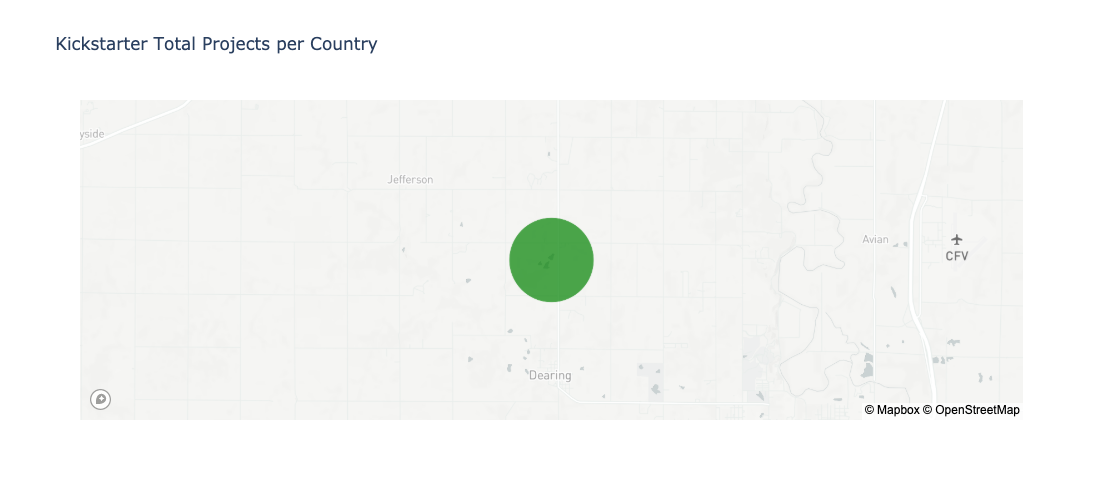

In [40]:
# This will create a scatter mapbox plot for Kickstarter and  their respective longitude and latitude plotted in with total number of projects.
ks_mapbox_plot = px.scatter_mapbox(
    ks_country_total_df,
    title='Kickstarter Total Projects per Country',
    lat='lat',
    lon='long',
    size='Total_number_of_projects',
    hover_name='Country',
    size_max=60,
    zoom= 11, center = {"lat": 37.090240, "lon": -95.712891},
    color_discrete_sequence=["green"],
    height=500,
    width=900
   
)
ks_mapbox_plot

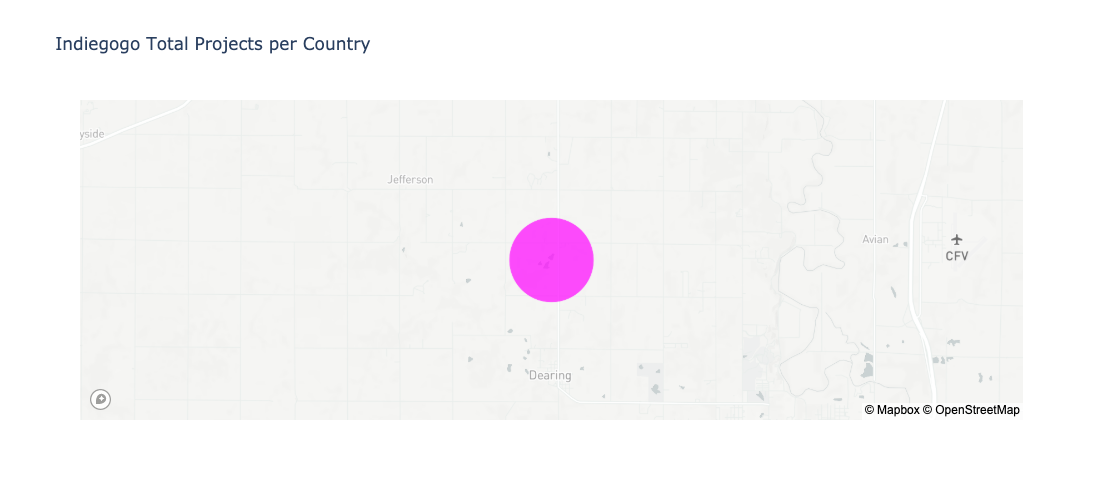

In [41]:
# This will create a scatter mapbox plot for Indiegogo and  their respective longitude and latitude plotted in with total number of projects.
indiegogo_mapbox_plot = px.scatter_mapbox(
    indiegogo_country_total_df,
    title='Indiegogo Total Projects per Country',
    lat='lat',
    lon='long',
    size='Total_number_of_projects',
    hover_name='Country',
    size_max=60,
    zoom= 11, center = {"lat": 37.090240, "lon": -95.712891},
    color_discrete_sequence=["fuchsia"],
    height=500,
    width=900
   
)
indiegogo_mapbox_plot

## General Summary Stats for Indiegogo

In [ ]:
indiegogo_summary_df = load_full_table("indie_gogo")

indiegogo_summary_df = indiegogo_summary_df.drop(columns=["ID", "name", "index", "deadline", "launched", "state", "lat", "long"])

indiegogo_summary_df = indiegogo_summary_df.describe()

indiegogo_summary_df